In [1]:
library(glmnet)
library(tidyverse)
library(superheat)

Loading required package: Matrix

Loaded glmnet 3.0-2


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



In [2]:
set.seed(423435)

In [3]:
load('../data/organSystem.Rdata')

In [4]:
load('../data/lateData.Rdata')

In [5]:
normalize <- function(x){return(x / sum(x))}

In [6]:
get_os_prediction_from_PP <- function(A.matrix, os, sub = '_4'){
    # A.matrix is the matrix of pp coefficients
    
    # change column headings to match with os data
    genes <- gsub('\\..*', '', colnames(A.matrix))
    genes <- gsub('\\_.*', '', genes)
        
    # extract those genes for which we have annotations
    A.matrix <- A.matrix[ , genes %in% rownames(os)] 
    
    os.subset <- os[genes[genes %in% rownames(os)], ]
    
#     print(dim(os.subset))
#     print(dim(A.matrix))
        
    # get the late stage annotations
    # they have names *_4
    os.names <- colnames(os)
    CV.late4 <- os.names[grep(sub, os.names)]
    
    CV.late4 <- CV.late4[CV.late4 != paste0('imagPR', sub)] # not enough genes w this annotation
    
    coefficients <- matrix(0, dim(A.matrix)[1] + 1, length(CV.late4))
    error_lasso_PP <- matrix(0,length(CV.late4), 1)
    
    for(i in 1:length(CV.late4)){
        y <- os.subset[, CV.late4[i]]
        
        if (sum(y > 0) > 10){
#             print(CV.late4[i])
#             print(sum(y > 0))
            cvfit <- cv.glmnet(t(A.matrix), y, family = 'binomial', 
                           type.measure = "auc")
            coefficients[,i] <- as.matrix(coef(cvfit, s = "lambda.1se"))
            error_lasso_PP[i, ] <- cvfit$cvm[cvfit$lambda == cvfit$lambda.1se]
        }else{
            print(CV.late4[i])
        }
    }

    rownames(coefficients) <- c('intercept', rownames(A.matrix))
    colnames(coefficients) <- sub(paste0(sub, "*"), " ", CV.late4)
    
    rownames(error_lasso_PP) <- sub(paste0(sub, "*"), " ", CV.late4)

    coeff_no_int <- coefficients[2:dim(coefficients)[1], ]
    
    return(list(coefficients = coeff_no_int, 
                error = error_lasso_PP))
}

# Predictions with 19 PPs

In [7]:
alpha_file <- '../scripts/staNMFDicts/K=19/alpha_99.csv'
alpha19 <- read.csv(alpha_file)[, -1]

In [8]:
lasso_pred19 <- get_os_prediction_from_PP(alpha19, os)

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


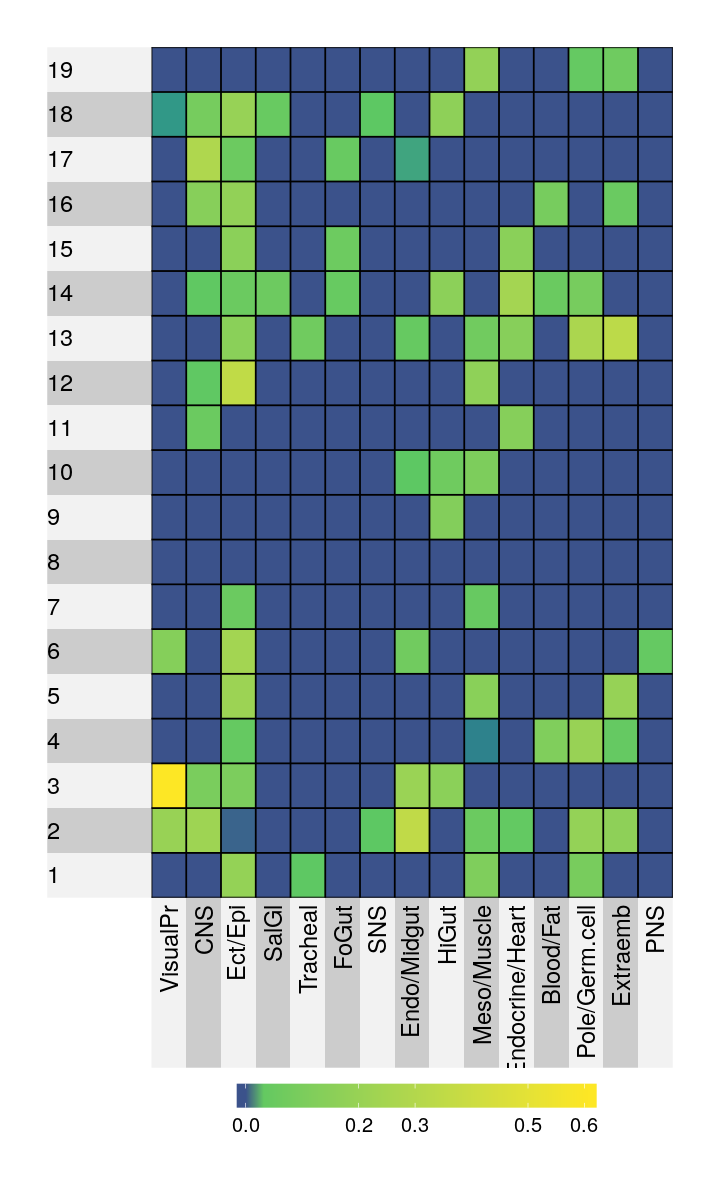

In [9]:
options(repr.plot.width = 6, repr.plot.height = 10)

superheat(abs(lasso_pred19$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right")

# ,
#           yt = lasso_pred19$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


# predictions using 8 PPs

In [10]:
alpha_file <- '../scripts/staNMFDicts/K=8/alpha_99.csv'
alpha8 <- read.csv(alpha_file)[, -1]

In [11]:
lasso_pred8 <- get_os_prediction_from_PP(alpha8, os)

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


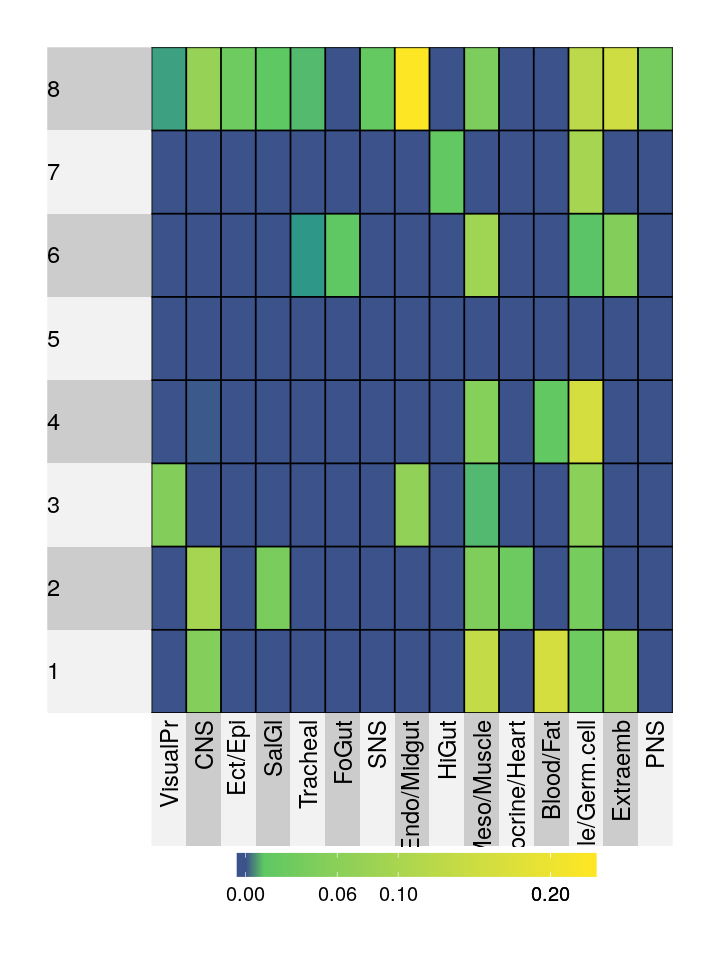

In [12]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred8$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right")

# , 
#           yt = lasso_pred8$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


# predictions using 12 PPs

In [7]:
alpha_file <- '../scripts/staNMFDicts/K=12/alpha_99.csv'
alpha12 <- read.csv(alpha_file)[, -1]

In [8]:
lasso_pred12 <- get_os_prediction_from_PP(alpha12, os)

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


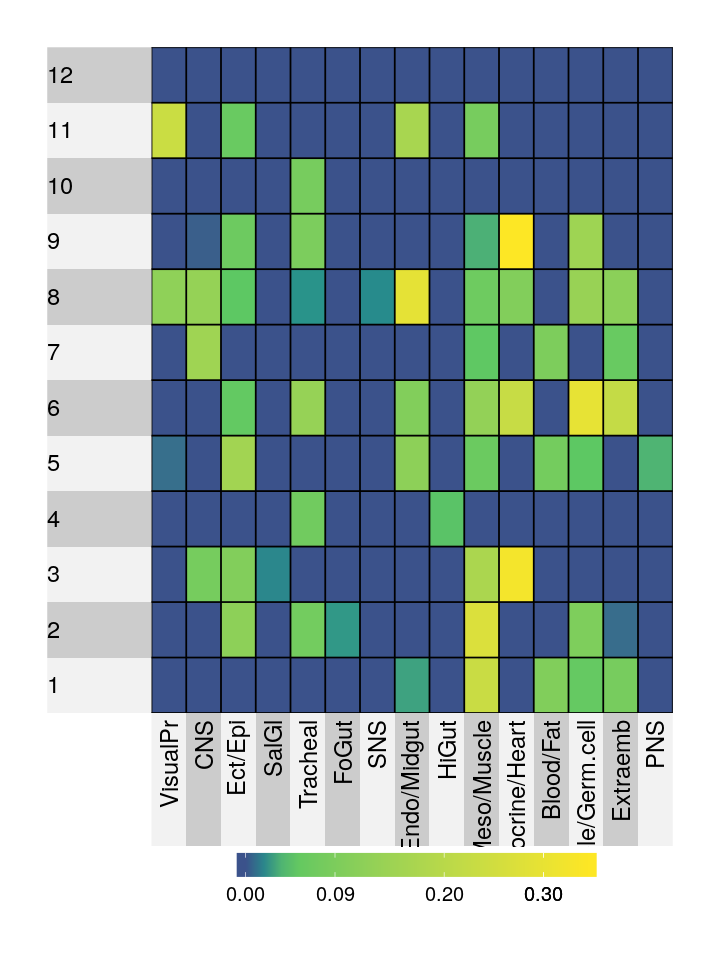

In [9]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred12$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right")

# , 
#           yt = lasso_pred12$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


# predictions using 5 PPs

In [16]:
alpha_file <- '../scripts/staNMFDicts/K=5/alpha_99.csv'
alpha5 <- read.csv(alpha_file)[, -1]

In [17]:
lasso_pred5 <- get_os_prediction_from_PP(alpha5, os)

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


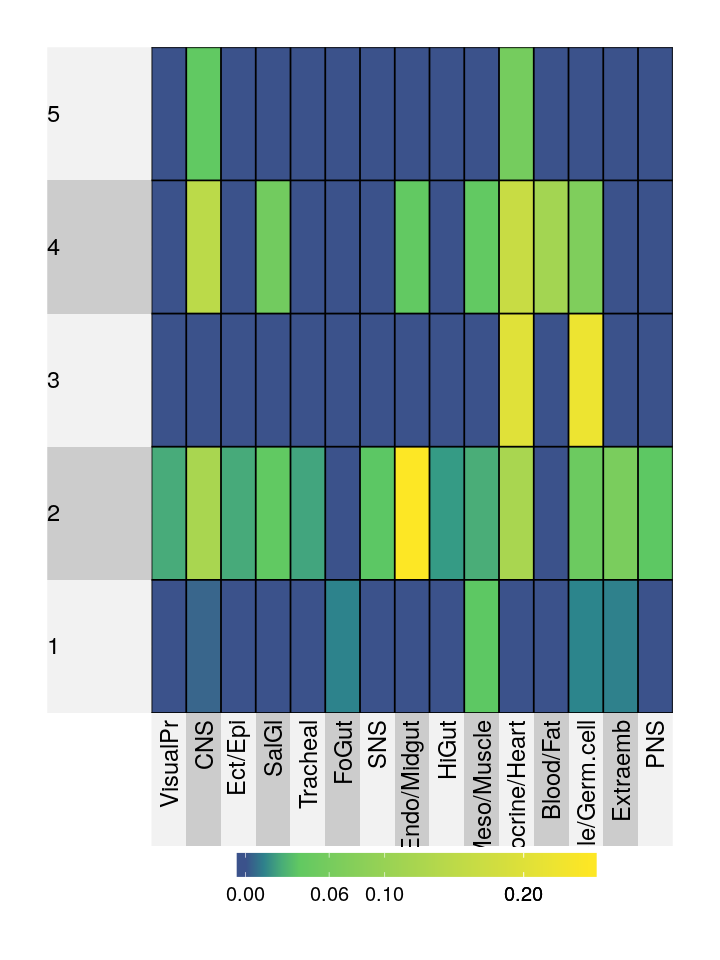

In [18]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred5$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right")

# , 
#           yt = lasso_pred5$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


In [19]:
load('../data/lateData.Rdata')

In [20]:
# predictions using full image

In [21]:
rownames(late$x) <- 1:dim(late$x)[1]

In [22]:
lasso_pred_full <- get_os_prediction_from_PP(late$x, os)

In [23]:
os.names <- colnames(os)
CV.late4 <- os.names[grep("_4", os.names)]
CV.late4 <- CV.late4[CV.late4 != 'imagPR_4']

# dataframe for full data
error_lasso_full_ <- lasso_pred_full$error
rownames(error_lasso_full_) <- c()
error_lasso_full_df <- data.frame(auc = error_lasso_full_, os = sub("_4*", " ", CV.late4))
error_lasso_full_df$features <- 'full'

# dataframe for 19 PP
error_lasso19_ <- lasso_pred19$error
rownames(error_lasso19_) <- c()
error_lasso19_df <- data.frame(auc = error_lasso19_, os = sub("_4*", " ", CV.late4))
error_lasso19_df$features <- '19_PP'

# dataframe for 12 PP
error_lasso12_ <- lasso_pred12$error
rownames(error_lasso12_) <- c()
error_lasso12_df <- data.frame(auc = error_lasso12_, os = sub("_4*", " ", CV.late4))
error_lasso12_df$features <- '12_PP'

# dataframe for 8 PP
error_lasso8_ <- lasso_pred8$error
rownames(error_lasso8_) <- c()
error_lasso8_df <- data.frame(auc = error_lasso8_, os = sub("_4*", " ", CV.late4))
error_lasso8_df$features <- '08_PP'

# dataframe for 5 PP
error_lasso5_ <- lasso_pred5$error
rownames(error_lasso5_) <- c()
error_lasso5_df <- data.frame(auc = error_lasso5_, os = sub("_4*", " ", CV.late4))
error_lasso5_df$features <- '05_PP'



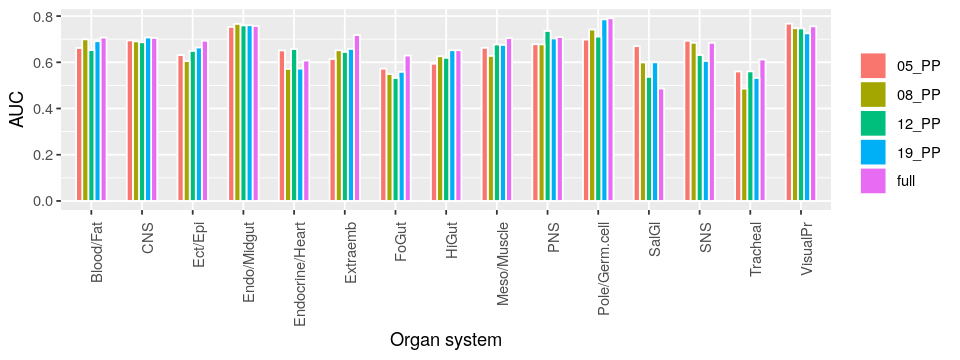

In [24]:
error_df <- rbind(error_lasso19_df, error_lasso12_df, error_lasso8_df, error_lasso5_df, error_lasso_full_df)

blank_theme <-   theme_bw() +
  theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 


library(ggplot2)
library(repr)
options(repr.plot.width=8, repr.plot.height=3)

# trach <- error_df$os[5]
# sns <- error_df$os[7]

error_df %>% 
    ggplot(aes(x=os,y=auc,fill=factor(features), width=.6))+
      geom_bar(stat="identity",position="dodge", color = 'white')+
      xlab("Organ system")+ylab("AUC") + theme(axis.text.x=element_text(angle=90,hjust=1)) +  
        guides(fill=guide_legend(title="")) 



# Get organ system predictions across stage

## for the 19 PP

In [25]:
alpha_file <- '../scripts/staNMFDicts/K=19/alpha_99.csv'
alpha19 <- read.csv(alpha_file)[, -1]

In [26]:
for(i in 1:4){
    
    # the stage to predict
    sub <- paste0('_', i)
    
    # the predictions
    lasso_pred <- get_os_prediction_from_PP(alpha19, os, sub = sub)
    
    # save coefficients
    coeffs <- abs(lasso_pred$coefficients)
    colnames(coeffs) <- paste0(colnames(coeffs), sub)
    
    if(i == 1){
        coeffs_all_stages <- coeffs
    }else{
        coeffs_all_stages <- cbind(coeffs_all_stages, coeffs)
    }    
}

coeffs_all_stages <- coeffs_all_stages[, sort(colnames(coeffs_all_stages))]


[1] "SalGl_1"
[1] "Tracheal_1"
[1] "SNS_1"
[1] "Endo/Midgut_1"
[1] "Endocrine/Heart_1"
[1] "Blood/Fat_1"
[1] "PNS_1"
[1] "SalGl_2"
[1] "Tracheal_2"
[1] "SNS_2"
[1] "Endocrine/Heart_2"
[1] "Blood/Fat_2"
[1] "PNS_2"
[1] "SalGl_3"
[1] "Tracheal_3"
[1] "SNS_3"
[1] "Endocrine/Heart_3"
[1] "PNS_3"


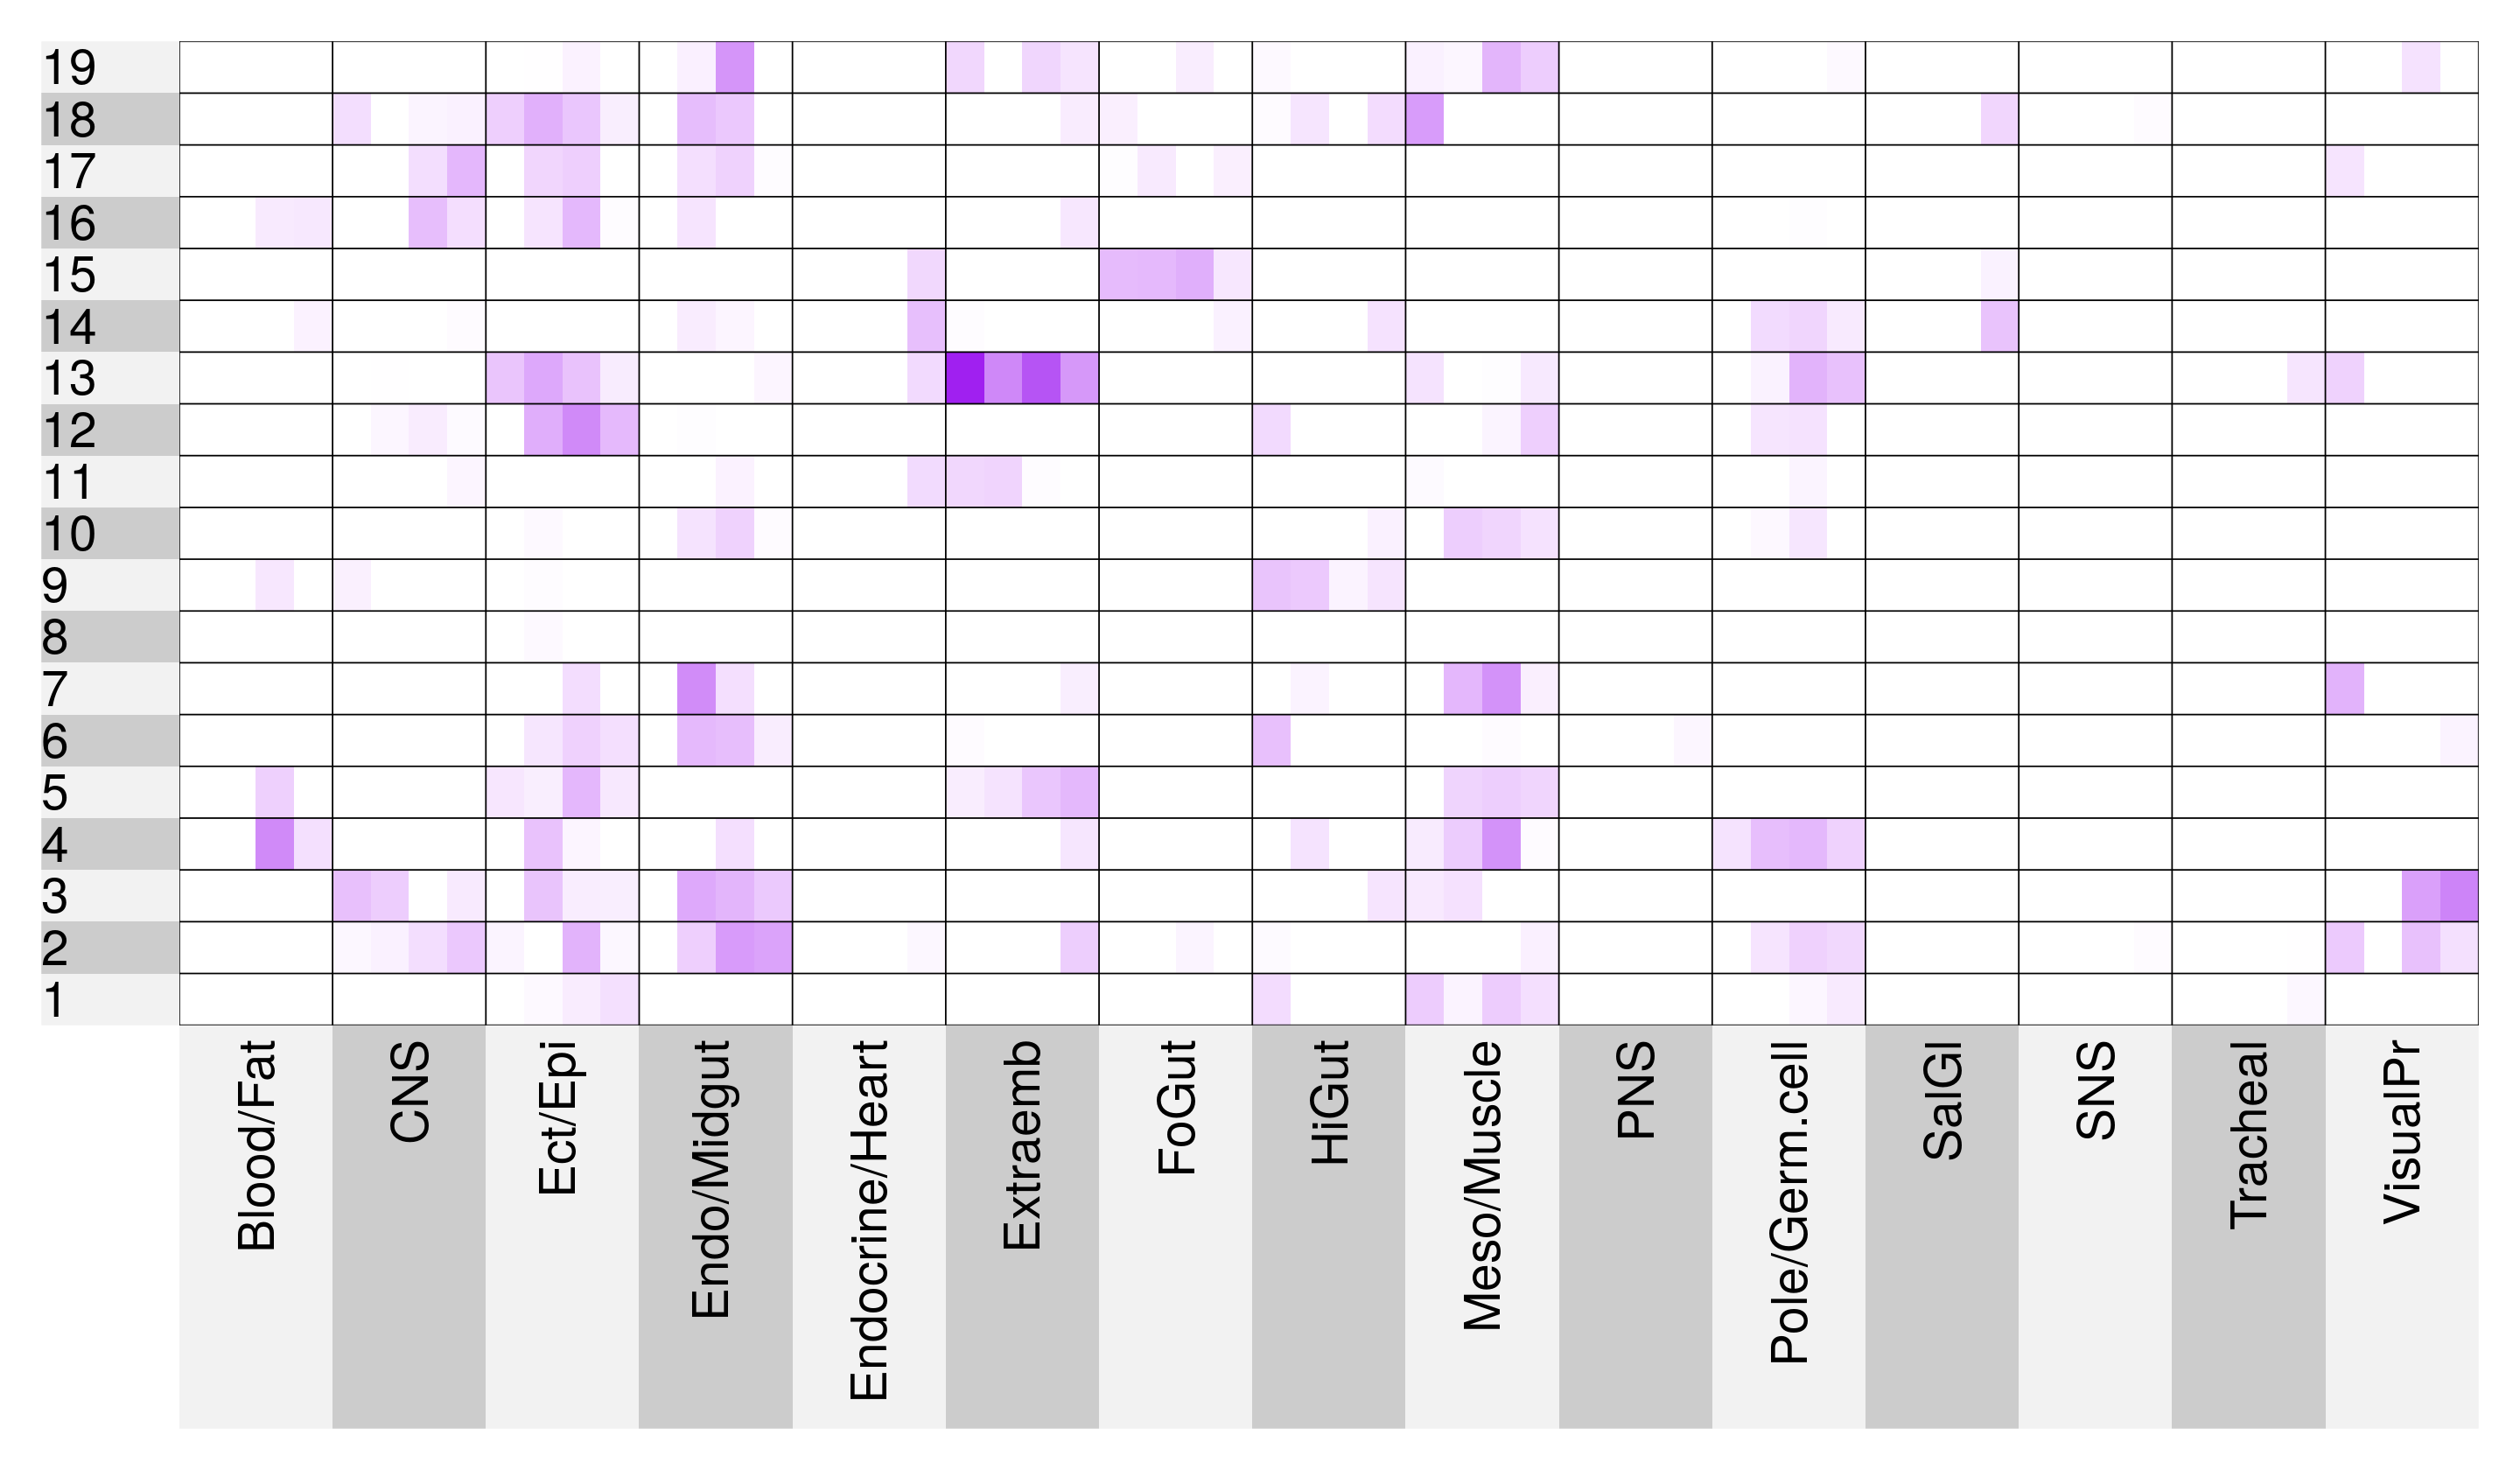

In [27]:
options(repr.plot.width = 24, repr.plot.height = 14)

superheat(coeffs_all_stages, bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          heat.pal = c('white', 'purple'), 
        membership.cols = gsub('_.*', '', colnames(coeffs_all_stages)), 
        heat.pal.values = c(0.0, 0.5, 1), 
         left.label.size = 0.06, 
         left.label.text.size = 12, 
         bottom.label.text.size = 12, 
         bottom.label.size = 0.41, 
         legend = FALSE)

# ,
#           yt = lasso_pred19$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


## For the 12 PP

In [10]:
alpha_file <- '../scripts/staNMFDicts/K=12/alpha_99.csv'
alpha12 <- read.csv(alpha_file)[, -1]

In [11]:
for(i in 1:4){
    
    # the stage to predict
    sub <- paste0('_', i)
    
    # the predictions
    lasso_pred <- get_os_prediction_from_PP(alpha12, os, sub = sub)
    
    # save coefficients
    coeffs <- abs(lasso_pred$coefficients)
    colnames(coeffs) <- paste0(colnames(coeffs), sub)
    
    if(i == 1){
        coeffs_all_stages <- coeffs
    }else{
        coeffs_all_stages <- cbind(coeffs_all_stages, coeffs)
    }    
}

coeffs_all_stages <- coeffs_all_stages[, sort(colnames(coeffs_all_stages))]


[1] "SalGl_1"
[1] "Tracheal_1"
[1] "SNS_1"
[1] "Endo/Midgut_1"
[1] "Endocrine/Heart_1"
[1] "Blood/Fat_1"
[1] "PNS_1"
[1] "SalGl_2"
[1] "Tracheal_2"
[1] "SNS_2"
[1] "Endocrine/Heart_2"
[1] "Blood/Fat_2"
[1] "PNS_2"
[1] "SalGl_3"
[1] "Tracheal_3"
[1] "SNS_3"
[1] "Endocrine/Heart_3"
[1] "PNS_3"


In [12]:
rownames(coeffs_all_stages) <- paste0('lPP', rownames(coeffs_all_stages))

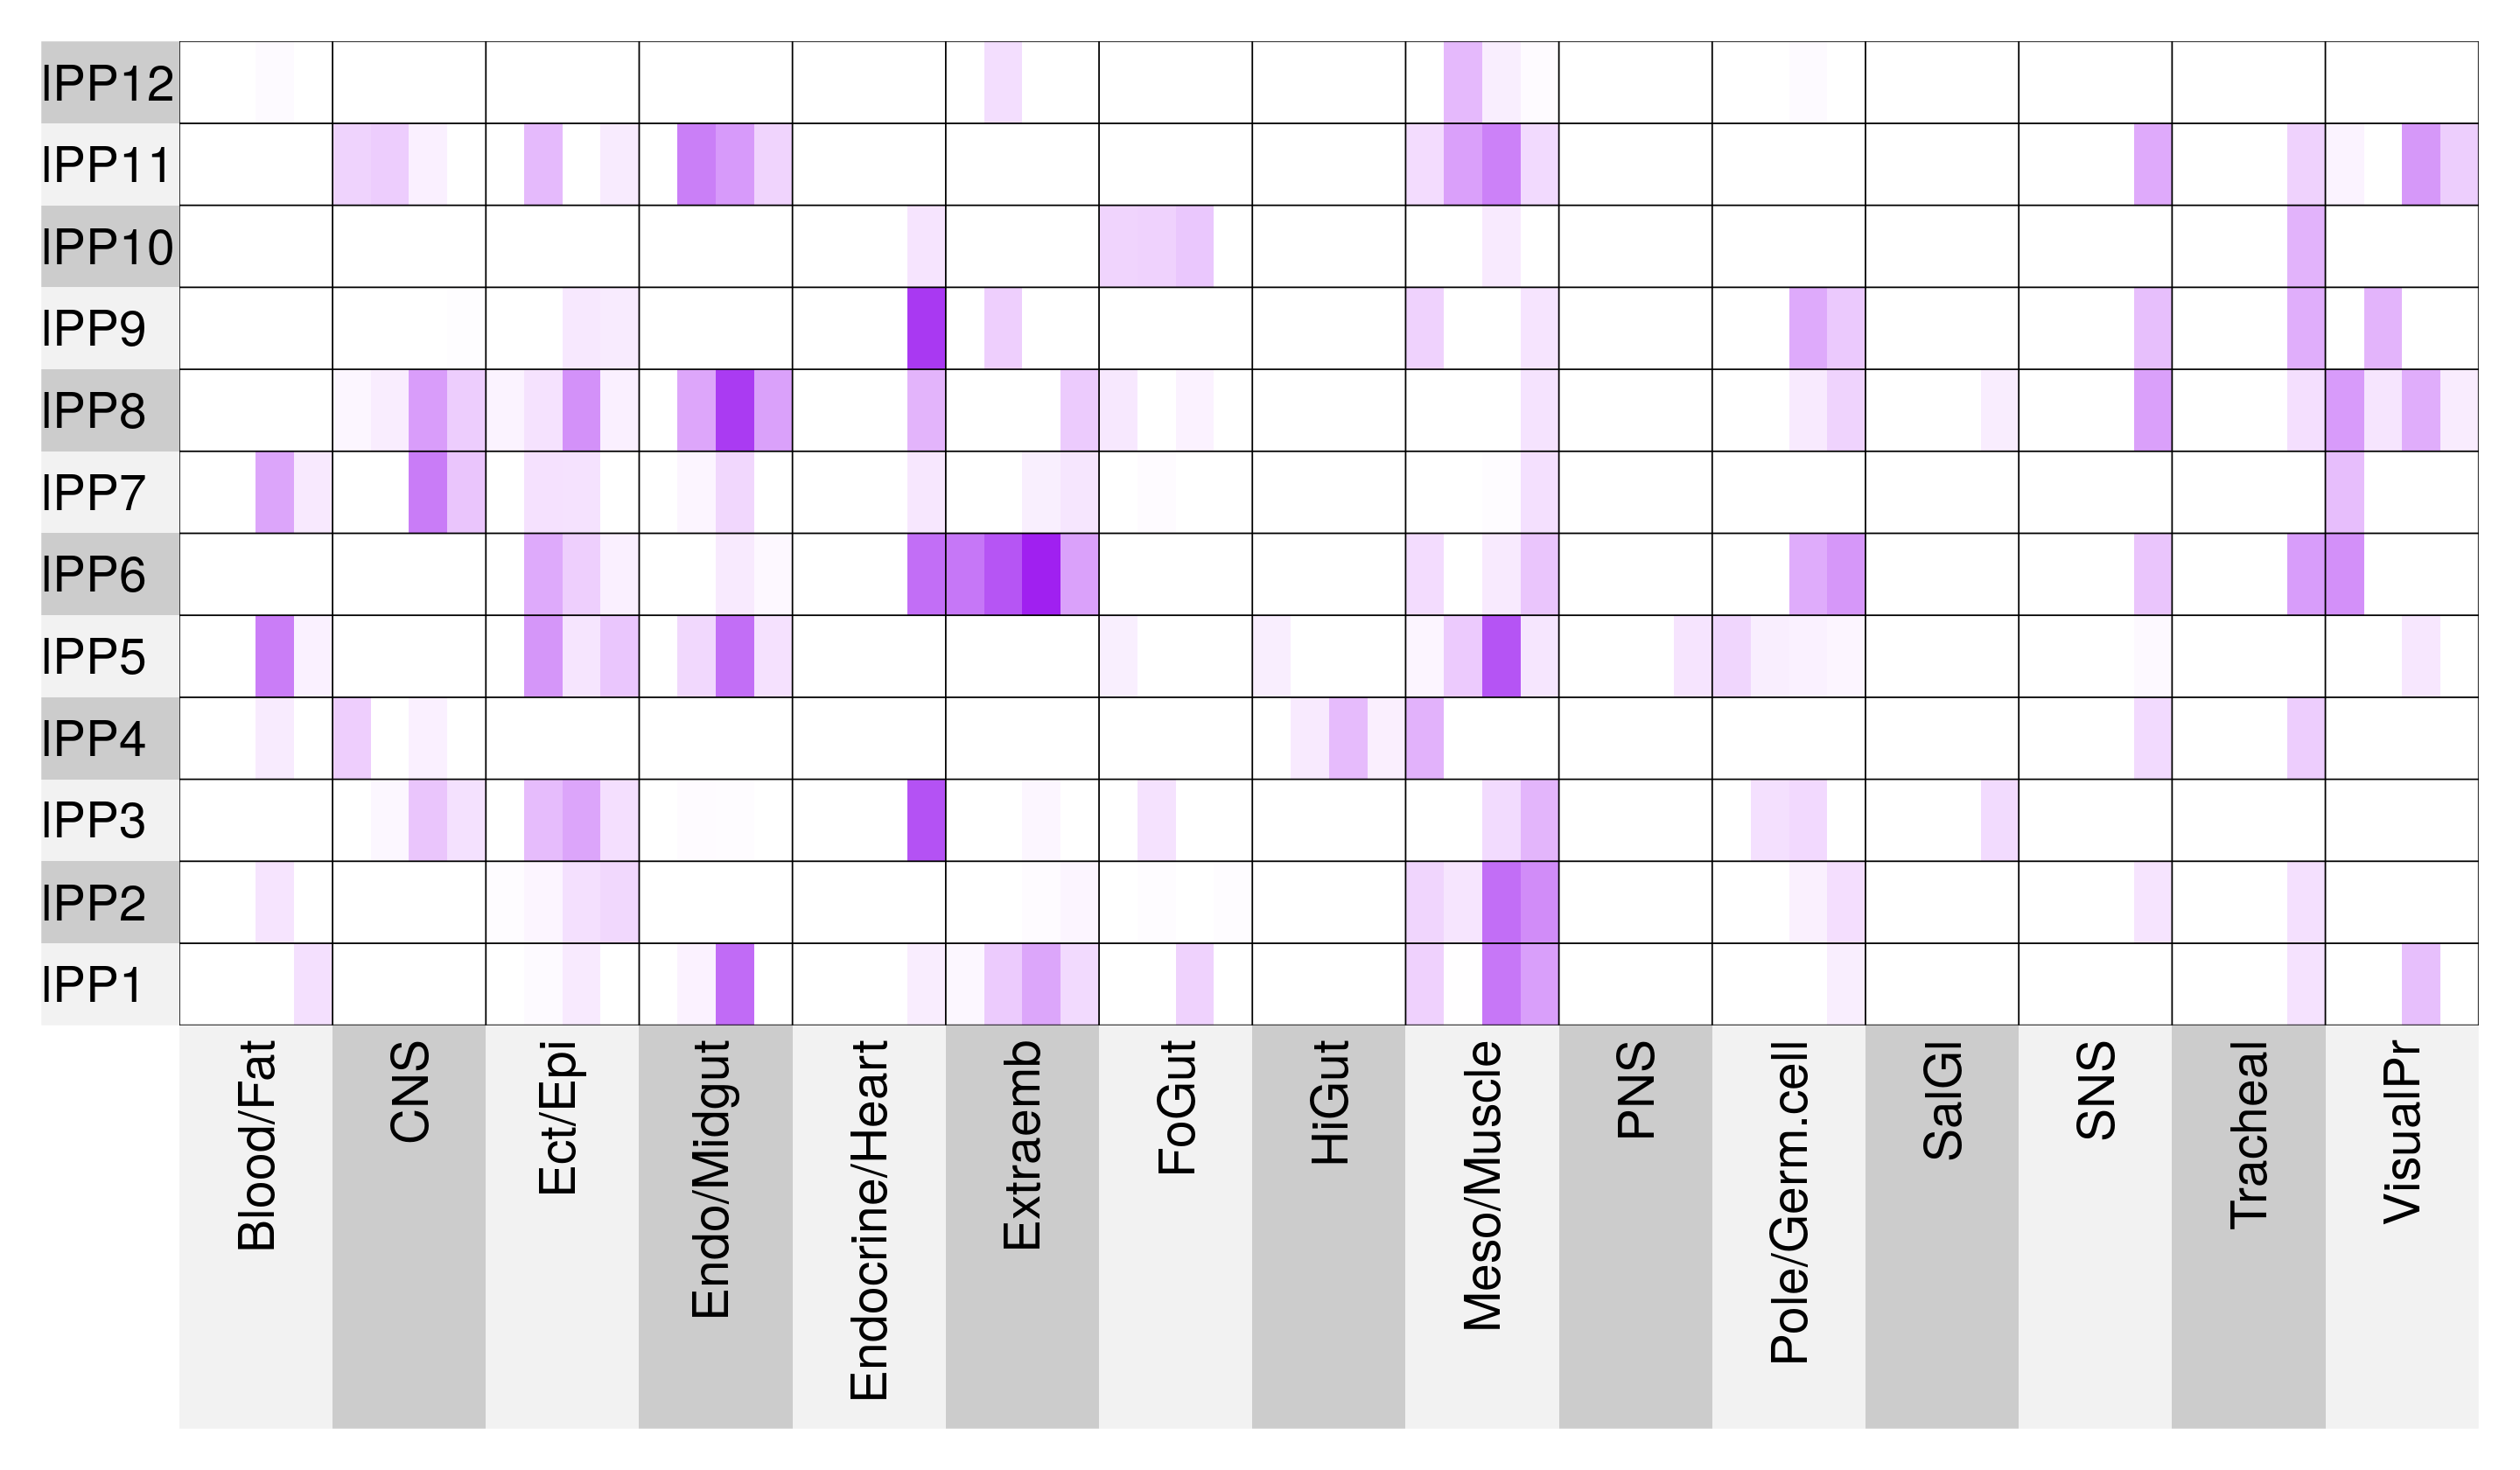

In [13]:
options(repr.plot.width = 24, repr.plot.height = 14)

superheat(coeffs_all_stages, bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          heat.pal = c('white', 'purple'), 
        membership.cols = gsub('_.*', '', colnames(coeffs_all_stages)), 
        heat.pal.values = c(0.0, 0.5, 1), 
         left.label.size = 0.06, 
         left.label.text.size = 12, 
         bottom.label.text.size = 12, 
         bottom.label.size = 0.41, 
         legend = FALSE)

# ,
#           yt = lasso_pred19$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


## for the set of 5 PP

In [31]:
alpha_file <- '../scripts/staNMFDicts/K=5/alpha_99.csv'
alpha5 <- read.csv(alpha_file)[, -1]

In [32]:
for(i in 1:4){
    
    # the stage to predict
    sub <- paste0('_', i)
    
    # the predictions
    lasso_pred <- get_os_prediction_from_PP(alpha5, os, sub = sub)
    
    # save coefficients
    coeffs <- abs(lasso_pred$coefficients)
    colnames(coeffs) <- paste0(colnames(coeffs), sub)
    
    if(i == 1){
        coeffs_all_stages <- coeffs
    }else{
        coeffs_all_stages <- cbind(coeffs_all_stages, coeffs)
    }    
}

coeffs_all_stages <- coeffs_all_stages[, sort(colnames(coeffs_all_stages))]


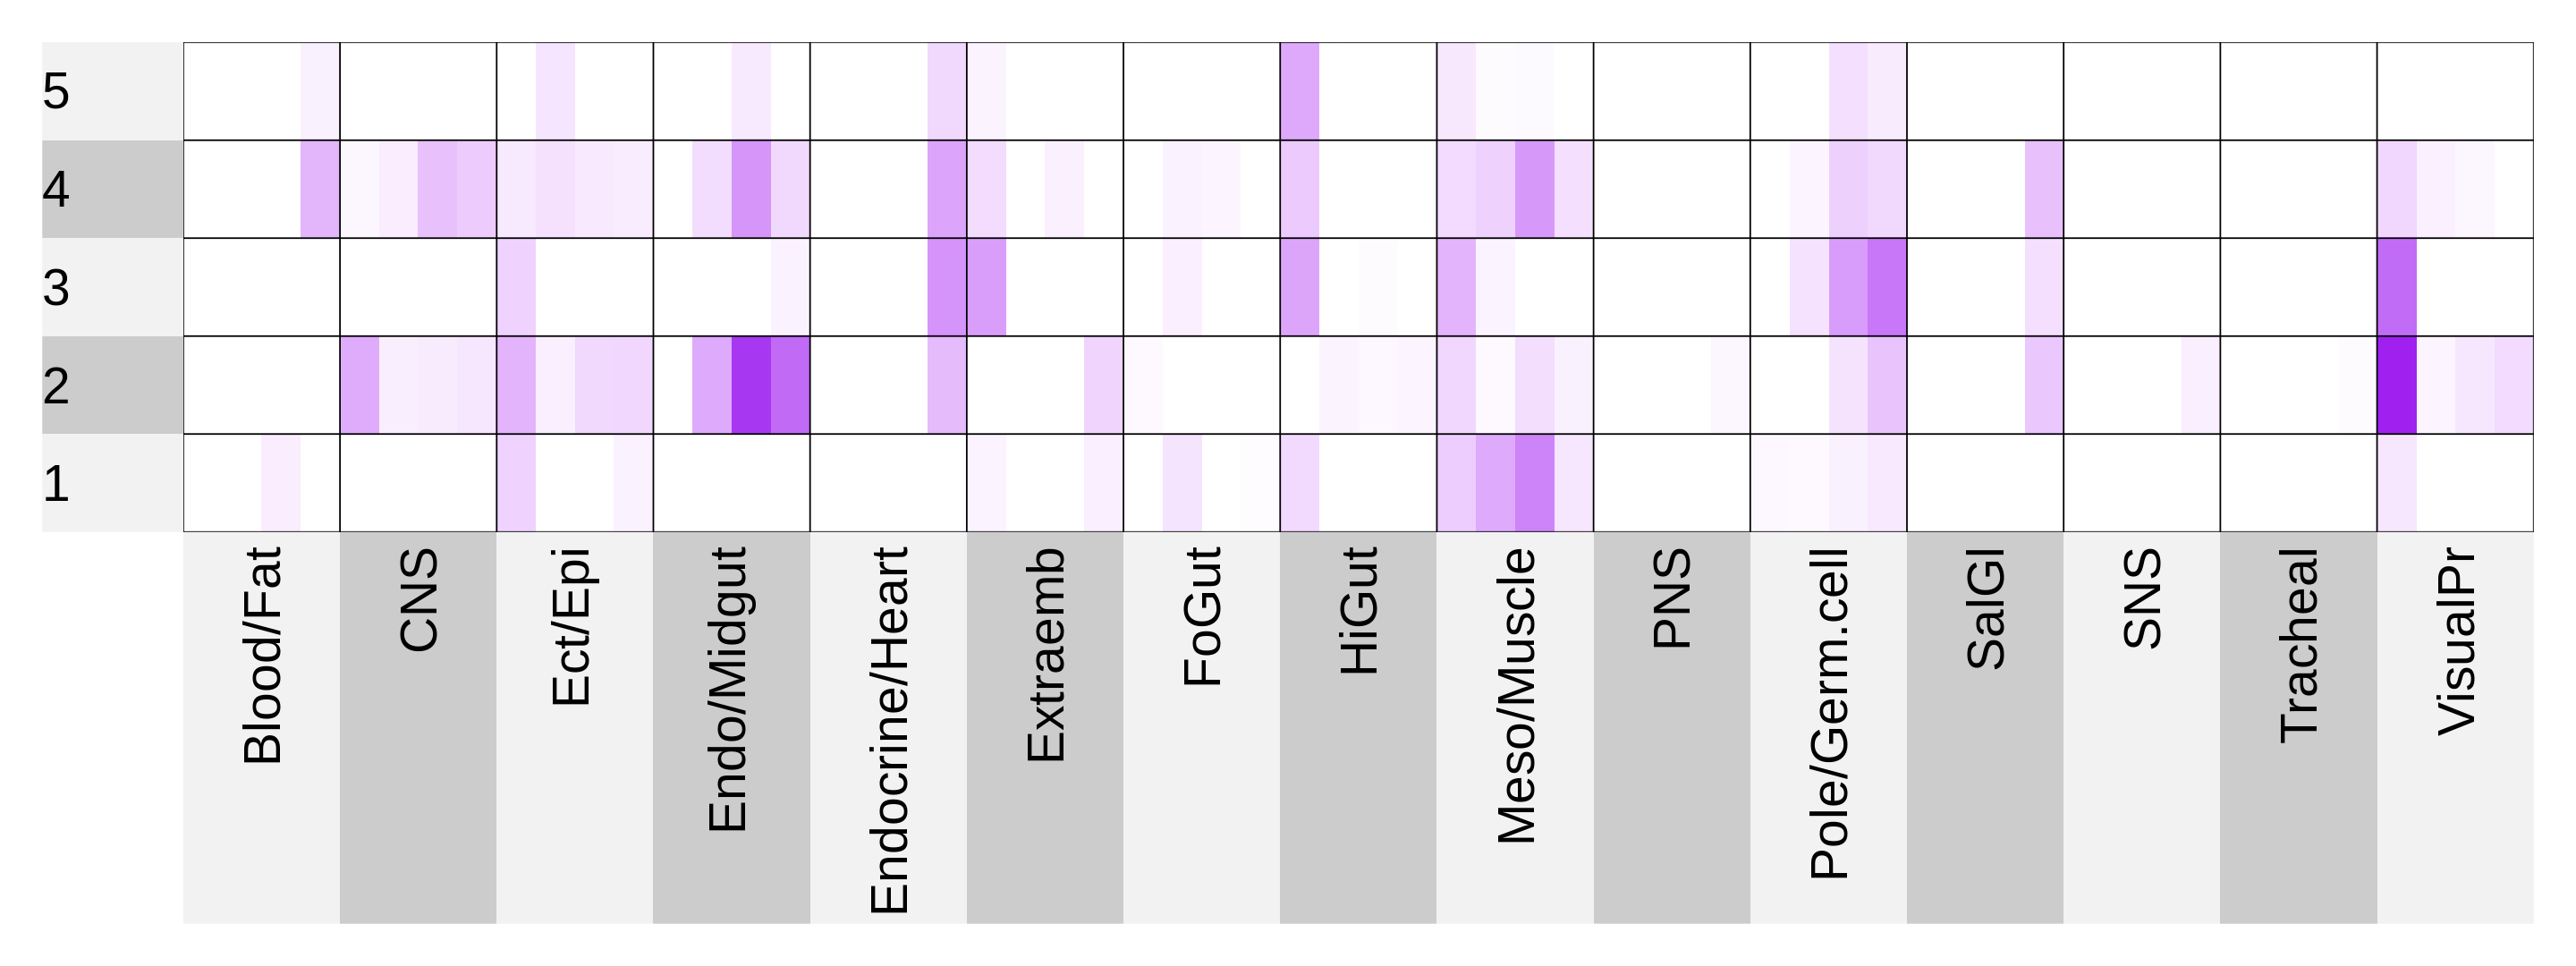

In [36]:
options(repr.plot.width = 24, repr.plot.height = 9)

superheat(coeffs_all_stages, bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          heat.pal = c('white', 'purple'), 
        membership.cols = gsub('_.*', '', colnames(coeffs_all_stages)), 
        heat.pal.values = c(0.0, 0.5, 1), 
         left.label.size = 0.06, 
         left.label.text.size = 12, 
         bottom.label.text.size = 12, 
         bottom.label.size = 0.8, 
          legend = FALSE)

# ,
#           yt = lasso_pred19$error, yt.axis.name = "auc",
#           yt.plot.type = "bar", title = "late stage _4 annotations")


In [15]:
source('../utils/plottingUtilities.R')

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid



In [16]:
plot_all_PPs(PPs[, -1], late$x)

ERROR: Error in seq.default(1, dim(dict)[2], by = 1): object 'PPs' not found
